# Forex Analysis

In [1]:
import sys
sys.path.insert(0, r"..//..//")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from hotstepper import Bases
from hotstepper import Basis
from hotstepper import Steps, Step
from hotstepper.utilities import rolling_window, prepare_datetime,get_epoch_start,get_epoch_end,float_to_date

import warnings
warnings.filterwarnings("ignore")


Load the data from a csv into a dataframe, as this provides the easiest way to process the raw data in readiness to use within HotStepper.

In [2]:
df_gbpusd_h1 = pd.read_csv(r'..//..//data//forex//GBPUSD_H1.csv',delimiter='\t',parse_dates=['Time'])
df_gbpusd_h1.head()


Time     Open     High      Low    Close  Volume
0 2013-01-28 10:00:00  1.57474  1.57475  1.57243  1.57243    8337
1 2013-01-28 11:00:00  1.57245  1.57263  1.57050  1.57050    8119
2 2013-01-28 12:00:00  1.57049  1.57329  1.57049  1.57257   11026
3 2013-01-28 13:00:00  1.57256  1.57389  1.57102  1.57366   11717
4 2013-01-28 14:00:00  1.57366  1.57431  1.57133  1.57171   11911

With a dataframe loaded, we can pass the dataframe in and specify which columns should be read with our steps data, since we have a monotonic series (there is a single value of y for each value of x), we want to automatically create the difference between time steps, this is easily asked for with the convert_delta = True parameter.

It should also be noted, we parsed the datetime field when loaded the dataframe, in this case the "Time" field, since this is already parsed and typed as datetime, HotStepper will detect this and automatically set the using_datetime = True parameter during the loading process.

In the event of an error or some confusion in the data loaded, setting this paramter explicitly will ensure the key values are typed as datetime.

<AxesSubplot:>

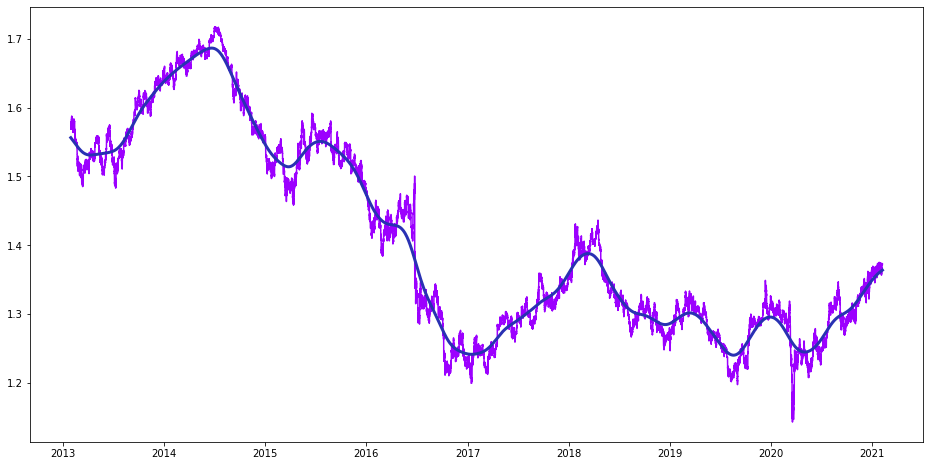

In [3]:
gbpusd_h1_open_steps = Steps.read_dataframe(df_gbpusd_h1,start = 'Time',weight='Open',convert_delta=True)
ax = gbpusd_h1_open_steps.plot()
gbpusd_h1_open_steps.smooth_plot(ax=ax,linewidth=3)



We got a nice visual of the data and a quick smooth plot, this is handy to get a feel for the data, if we want to understand the data more than just a quick visual, but hey, we're busy people, so we want understanding, quickly, HotStepper has this covered, we can use the summary() method on the steps, this will create a very nice summary of our dataset in one line of code.

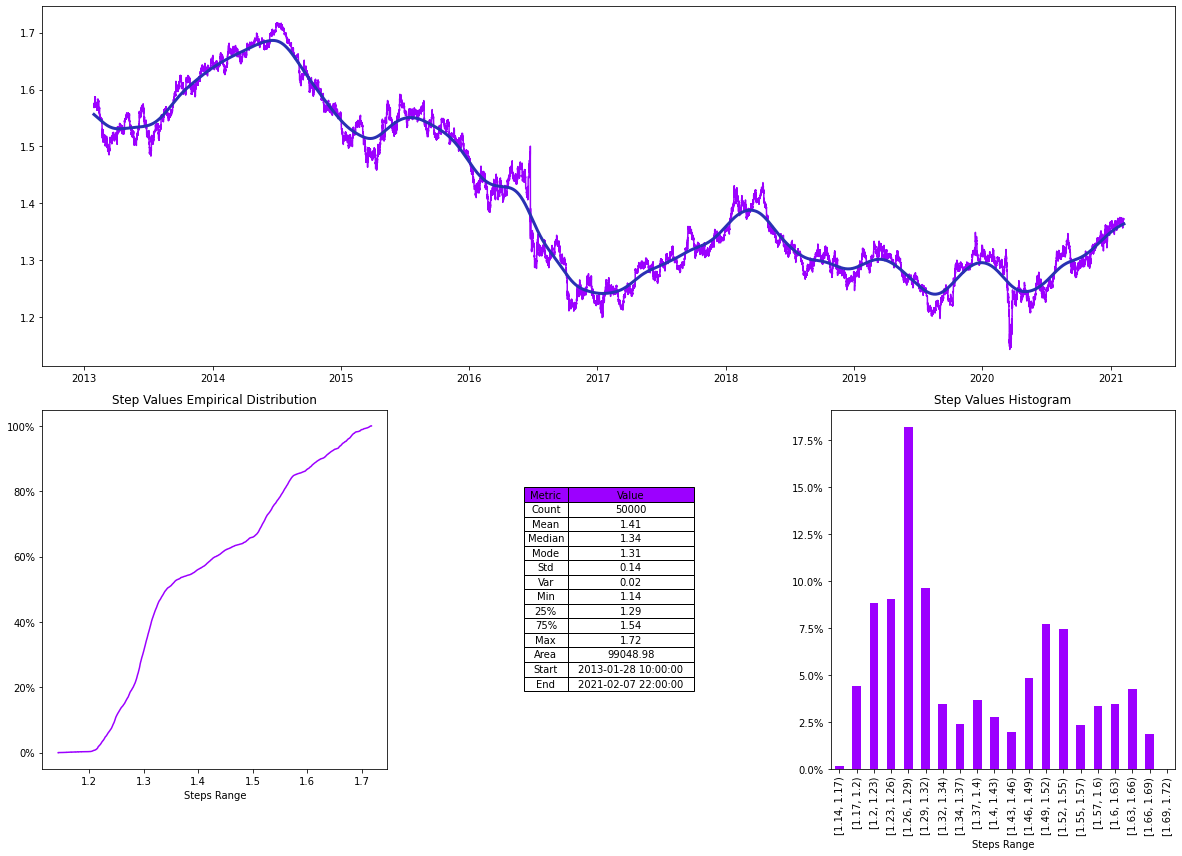

In [4]:
gbpusd_h1_open_steps.summary();

We can look more closely at how this pair moved differently between 2017 and 2018, we first create new steps for these date ranges and have a look at what we have. A simple way to understand how these two years are related is to compare if, only aggregate, the price was higher, lower or the same.

In [5]:
gbpusd_h1_open_steps_2017 = gbpusd_h1_open_steps.clamp(lbound=pd.Timestamp(2016,12,31),ubound=pd.Timestamp(2017,12,31))
gbpusd_h1_open_steps_2018 = gbpusd_h1_open_steps.clamp(lbound=pd.Timestamp(2017,12,31),ubound=pd.Timestamp(2018,12,31))

(gbpusd_h1_open_steps_2018.integrate())/gbpusd_h1_open_steps_2017.integrate()

1.0365144559041157

So taking the ratio of the area under the curve across the two years, we see that 2018 was approximately 3.7% higher than 2017, how easy was that!

Now we can also compare the effect different smoothing bases have and finally compare that with a centred rolling average, this can be done very quickly on the same chart for the same dataset by using the ability to pass in a Basis for each specific smooth plot.

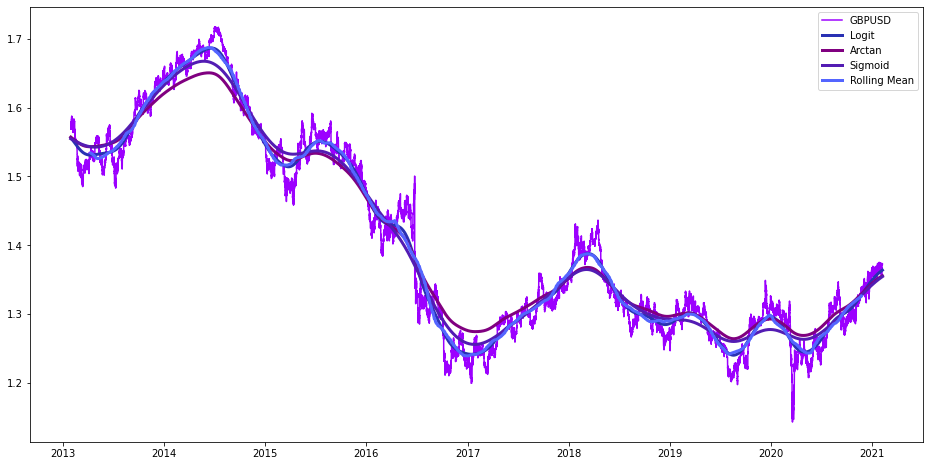

In [6]:
ax = gbpusd_h1_open_steps.plot(label='GBPUSD')
gbpusd_h1_open_steps.smooth_plot(ax=ax,linewidth=3,label='Logit')
gbpusd_h1_open_steps.smooth_plot(ax=ax,linewidth=3,smooth_basis=Basis(Bases.arctan),label='Arctan')
gbpusd_h1_open_steps.smooth_plot(ax=ax,linewidth=3,smooth_basis=Basis(Bases.sigmoid),label='Sigmoid')


#and the rolling mean
gbpusd_h1_open_steps.plot_rolling_step(ax=ax,rolling_function=np.mean,window=2500,pre_mid_post='mid',linewidth=3,label='Rolling Mean')

ax.legend()


From the plot of the logit, arctan, sigmoid and centred rolling mean of the data, we can see the logit basis plot is very similar to the centred rolling mean, with the advantage of not needing the warm-up at the start and tends to be less sensitive to extreme changes, leading to a smoother curve.

Now we have a better view of the data and the effect of different basis functions on the smoothing, lets look more closely at 2017. We can simply clip that year out of the original data and investigate this portion with some smoothing.

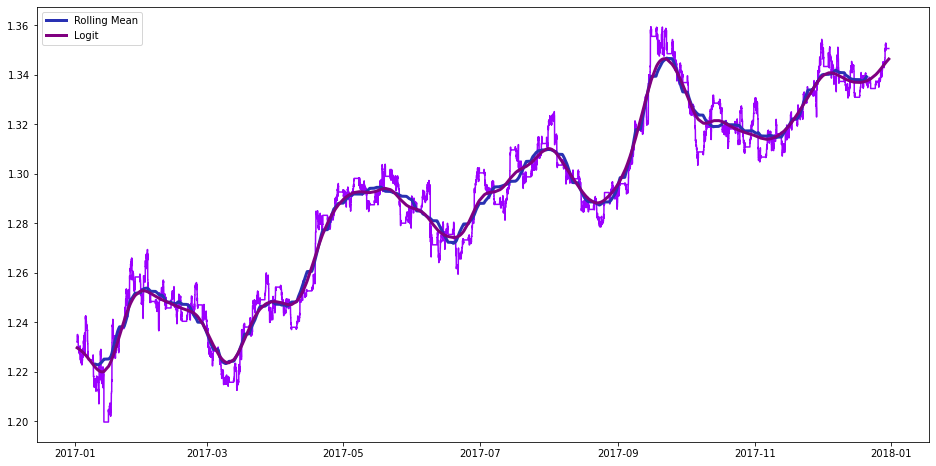

In [7]:
gbpusd_h1_open_steps_2017 = gbpusd_h1_open_steps.clip(pd.Timestamp(2017,1,1),pd.Timestamp(2017,12,31))
ax = gbpusd_h1_open_steps_2017.plot()
gbpusd_h1_open_steps_2017.plot_rolling_step(ax=ax,rolling_function=np.mean,window=300,pre_mid_post='mid',linewidth=3,label='Rolling Mean')
gbpusd_h1_open_steps_2017.smooth_plot(ax=ax,linewidth=3,label='Logit')

ax.legend()

An interesting analysis in forex is to understand when and by how much the price moves away and towards a centre line value, much like mean reversion. With HotStepper, we can generate a new steps object directly representing the difference by creating a smooth basis copy of the data, in this case the 2017 GBPUSD open steps with a logit basis, we can directly subtract this smoothed version of the data from the original noisy 2017 data to get the difference. With this in hand, we have all the power of the HotStepper tools.

<AxesSubplot:>

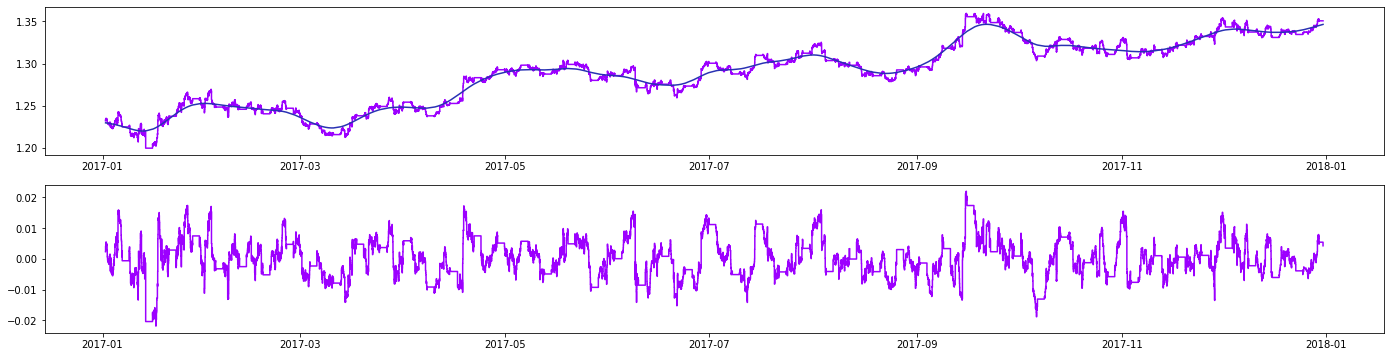

In [8]:
fig, (ax,ax2) = plt.subplots(nrows=2,figsize=(24,6))
gbpusd_h1_open_steps_2017_smooth = gbpusd_h1_open_steps_2017.copy()
gbpusd_h1_open_steps_2017_smooth.rebase(Basis(Bases.logit))

gbpusd_h1_open_steps_2017_delta = gbpusd_h1_open_steps_2017 - gbpusd_h1_open_steps_2017_smooth

gbpusd_h1_open_steps_2017.plot(ax=ax)
gbpusd_h1_open_steps_2017_smooth.smooth_plot(ax=ax)
gbpusd_h1_open_steps_2017_delta.plot(ax=ax2)

Get some quick statistics on the 2017 detla data with the describe() method. 

In [9]:
gbpusd_h1_open_steps_2017_delta.describe()

Metric                Value
0    Count                 6227
1     Mean                  0.0
2   Median                 -0.0
3     Mode                -0.02
4      Std                 0.01
5      Var                  0.0
6      Min                -0.02
7      25%                 -0.0
8      75%                  0.0
9      Max                 0.02
10    Area                  0.3
11   Start  2017-01-01 22:00:00
12     End  2017-12-31 00:00:00

We can generate all the summary, histogram etc. plots directly on the delta data, since this is another steps object.

<AxesSubplot:title={'center':'Step Values Histogram'}, xlabel='Steps Range'>

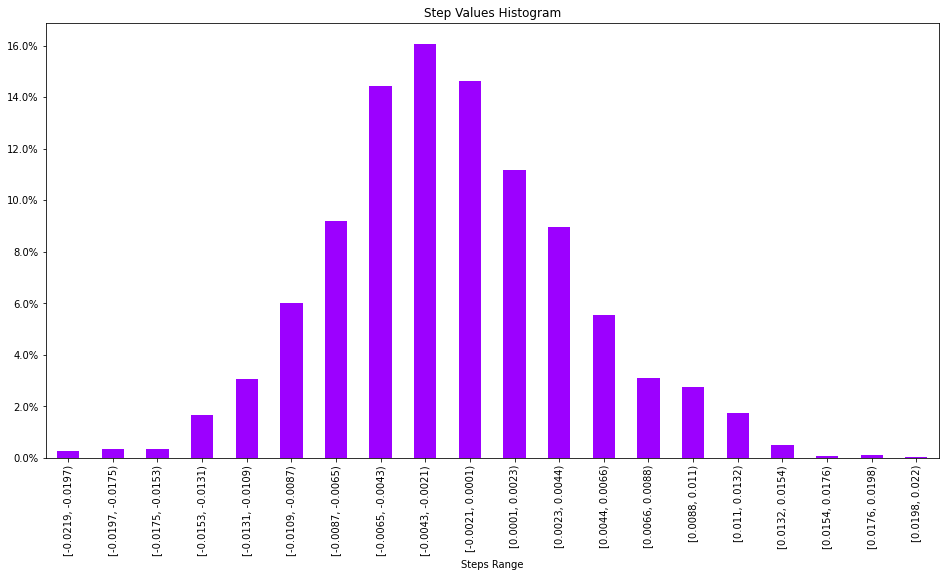

In [10]:
gbpusd_h1_open_steps_2017_delta.histogram_plot(precision=4)

<AxesSubplot:title={'center':'Steps Partial Autocorrelation for Lags = 20'}, xlabel='Lag'>

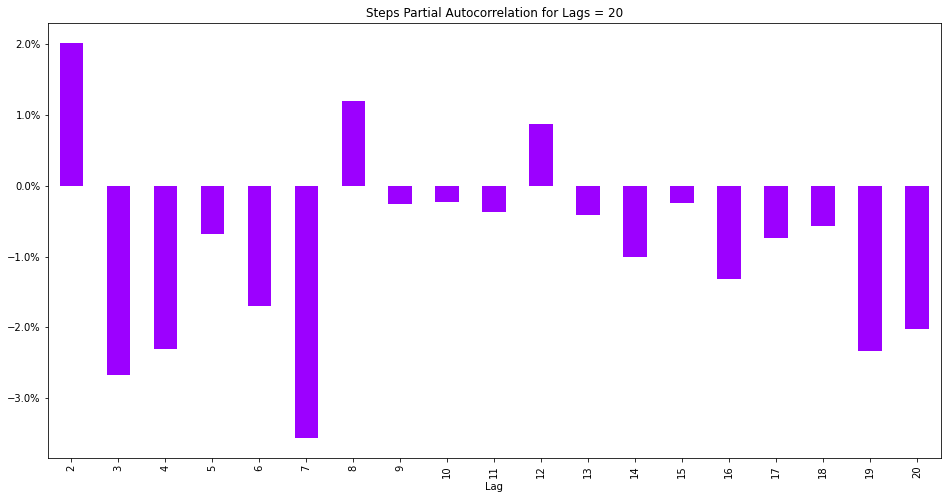

In [11]:
gbpusd_h1_open_steps_2017_delta.pacf_plot(20,2)

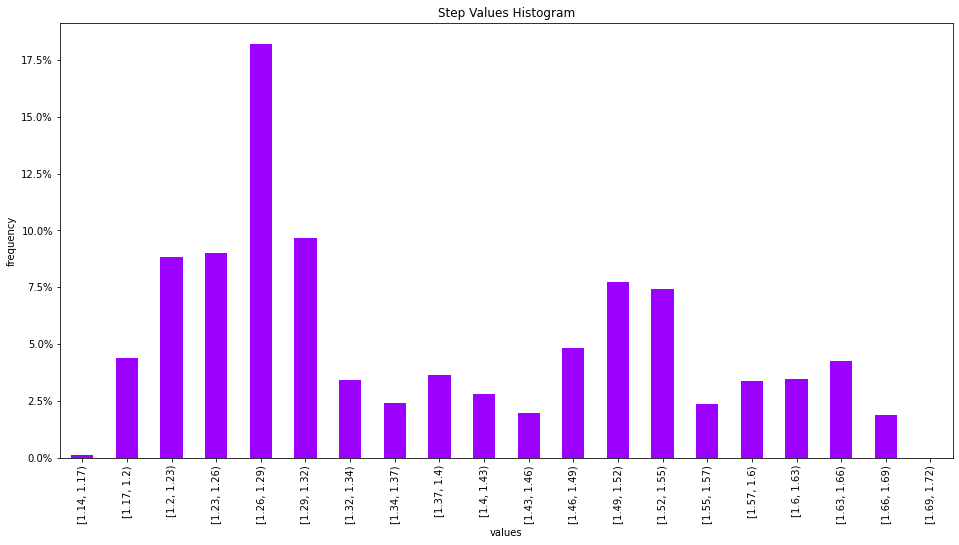

In [12]:
ax = gbpusd_h1_open_steps.histogram_plot(bins=20,xlabel='values',ylabel='frequency')

<AxesSubplot:title={'center':'Step Values Empirical Distribution'}, xlabel='Steps Range'>

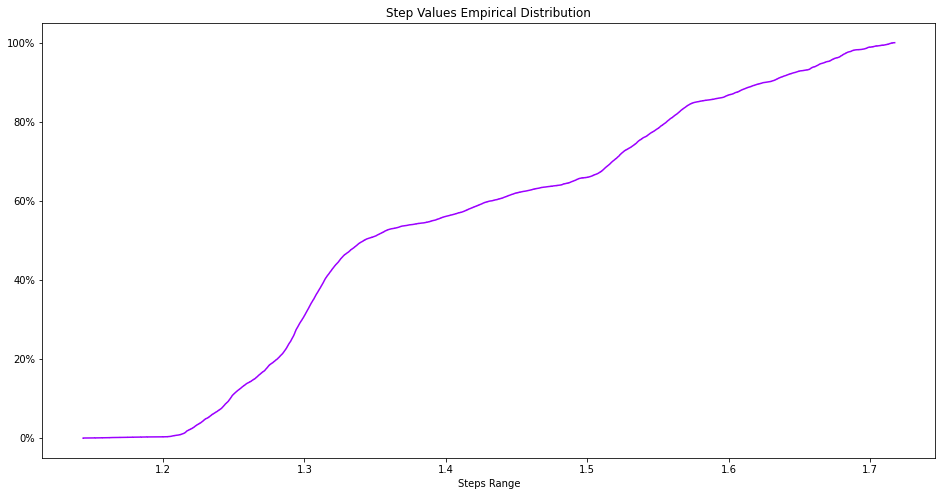

In [13]:
gbpusd_h1_open_steps.ecdf_plot()

We can quickly look at how the prices are related with a partial auto correlation plot. We know that the directly previous price is well correlated, as the open is the same as the previous close. We can exclude these and look back something simple like 24 steps, this is the last day of hourly open prices.

<AxesSubplot:title={'center':'Steps Partial Autocorrelation for Lags = 24'}, xlabel='Lag'>

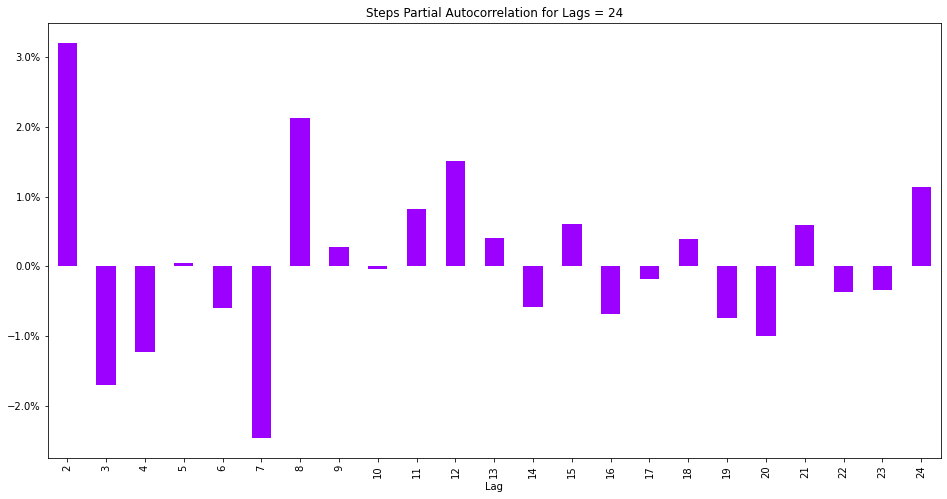

In [14]:
gbpusd_h1_open_steps_2017.pacf_plot(24,2)